In [1]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import re
from multiprocessing import Pool
from pandarallel import pandarallel
import bertopic
import json
from sklearn.model_selection import train_test_split

In [2]:
hate_df = pd.read_csv("losiento.csv")

In [3]:
hate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40000 non-null  int64 
 1   id          40000 non-null  object
 2   is_hater    40000 non-null  int64 
 3   tweets      40000 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [4]:
test_hate_df = pd.read_csv("TESTES.csv")

In [5]:
test_hate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   id          20000 non-null  object
 2   tweets      20000 non-null  object
 3   is_hater    20000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


In [6]:
test_hate_df.is_hater.value_counts()

2    20000
Name: is_hater, dtype: int64

In [7]:
hate_df = pd.concat([hate_df, test_hate_df])
hate_df.reset_index(inplace = True)

In [8]:
hate_df = hate_df.drop(columns=['Unnamed: 0'])

In [9]:
def word_cloud(df, feature):
    text = ' '.join([abstract for abstract in df[feature]])
    wordcloud = WordCloud(max_font_size=None, background_color='blue', collocations=False,
                      width=1600, height=1200).generate(text)
    return wordcloud

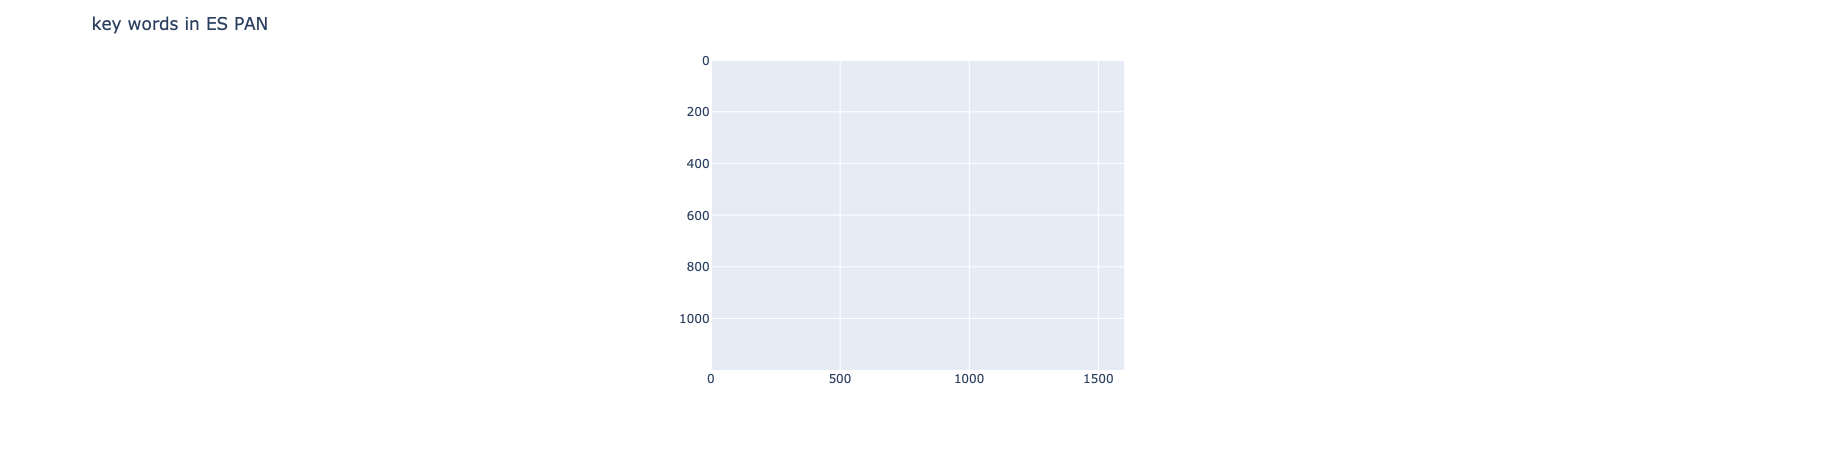

In [10]:
fig = px.imshow(word_cloud(hate_df, 'tweets'))
fig.update_layout(title_text='key words in ES PAN')

In [12]:
SYMBOLS_TO_ISOLATE = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
SYMBOLS_TO_REMOVE = '\n\r\xa0\ue014\t\uf818\uf04a\xad\uf0e0\u200b\u200eعدويهصقأناخلىبمغرЕ\u202a\u202c🏻ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢשלוםבי‼\x81エンジ故障\u2009ᴵ͞\u200fאעכחஜᴠ‐\x7fἐὶήιὲκἀίῃἴξＨ\ufeff\u2028\u3000تحكسة👮💙فزط\u2008🏾\x08‑地獄谷улкнПоАН歌舞伎הмυтѕ⤵\u200aэпрд\x95\u2002\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13\ue602άοόςέὸתמדףנרךצט\uf0b7\uf04c\x9f\x10成都\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス外国人关系Сб💋💀🎄💜ьыгя不是\x9c\x9d🗑\u2005💃📣༼つ༽ḷЗз▱ц￼卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡й\u2003🚀🤴ʲшчИОРФДЯМюж🖑ὐύύ特殊作戦群щ💨圆明园קℐ\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'
POSITIVE_EMOJI = '😜😎😁💖😀😂😄😋👏😊👍😃😘👌🙂😉😏🎉😅👻🙃😆🤗🤓😌🤑😛🤣😝💪😗🥰😇🤠🤡🥳🥴🤩😺😸😹😻😽✌️🤟🤘'
NEGATIVE_EMOJI = '🥵😢👎😱😳😧🙀😐😕😮😖😟😡😠😤😞😭😥😔😓😪😨😩🙁😵😒͝😣😲😯🤢َِ😰👿👿🤥😬😷🤒🤕🤯🤬🥺🙀😿😾🖕🏻🖕🏼'
FLAG_EMOJI = '🇯🇵🇰🇷🇩🇪🇨🇳🇺🇸🇫🇷🇪🇸🇮🇹🇲🇽🇮🇳🇷🇺🇬🇧'
NEUTRAL_EMOJI = '🎤🐶️🍕🐵💵🔥💥🚌🌟💩💯⛽🚄🏼🚲😈🙏🎯🌹💔👊🙄⛺🍾🏽🎆🍻⏺🌏💞🚓🔔📚🏀👐🍽🎶🌺🤔🐰🐇🏈😺🌍🍔🐮🍁🍆🍑🌮🌯🤦🙈😴🆕👅👥👄🔄🔤👉👤🤧👶👲🔛🎓🏿🇺🇸🌠🐟💫💰🚬💎🐱🙆💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚🐾🐕🔗🚽🏆🎃🖐🙅⛲🍰🤐👆🙌💛👀🙊🙉'
ISOLATE_DICT = {ord(c):''.format(ord(c)) for c in SYMBOLS_TO_ISOLATE}
REMOVE_DICT = {ord(c):'' for c in SYMBOLS_TO_REMOVE}
FLAG_EMOJI_DICT = {ord(c):'' for c in FLAG_EMOJI}
NEUTRAL_EMOJI_DICT = {ord(c):'' for c in NEUTRAL_EMOJI}
POSITIVE_EMOJI_DICT = {ord(c):'' for c in POSITIVE_EMOJI}
NEGATIVE_EMOJI_DICT = {ord(c):'' for c in NEGATIVE_EMOJI}
#CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }


def handle_punctuation(text):
    text = text.translate(REMOVE_DICT)
    text = text.translate(NEUTRAL_EMOJI_DICT)
    text = text.translate(POSITIVE_EMOJI_DICT)
    text = text.translate(FLAG_EMOJI)
    text = text.translate(NEGATIVE_EMOJI_DICT)
    text = text.translate(ISOLATE_DICT)
    return text

#def clean_contractions(text, mapping=CONTRACTION_MAPPING):
#    specials = ["’", "‘", "´", "`"]
#    for s in specials:
#        text = text.replace(s, "'")
#    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
#    return text


def text_general_reworking(text):
    spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad',
              '\xa0']
    for space in spaces:
        text = text.replace(space, ' ')
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\.{2,}', ' ', text)
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', '', text)
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', '', text)
    text = re.sub(r'(<3|:\*)', '', text)
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', '', text)
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', '', text)
    text = re.sub(r'(:,\(|:\'\(|:"\()', '', text)
    #text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', text)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'\[math\]', ' LaTex math ', text)
    text = re.sub(r'\[\/math\]', ' LaTex math ', text)
    text = re.sub(r'\\', ' LaTex ', text)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub("([^\"^\'].\s)(\")([A-Z,a-z?])", r"\1\3", text)
    text = re.sub("(\')(.\")", r"\2", text)
    text = text.lower()
    if '-' in text:
        text = text.replace('-', ' - ')
    text.strip()
    return text

def text_preprocess(x):
    x = text_general_reworking(x)
    x = handle_punctuation(x)
    #x = clean_contractions(x)
    return x

In [13]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [14]:
def final_preprocess(df):
    df['tweets'] = df['tweets'].apply(lambda x: text_preprocess(x))
    df['tweets'] = df['tweets'].apply(html.unescape)
    return df

In [15]:
pandarallel.initialize()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
hate_df['processed_tweets'] = hate_df['tweets'].parallel_apply(text_preprocess)

In [17]:
hate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             60000 non-null  int64 
 1   id                60000 non-null  object
 2   is_hater          60000 non-null  int64 
 3   tweets            60000 non-null  object
 4   processed_tweets  60000 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [18]:
hate_df['len_initial'] = hate_df['tweets'].apply(lambda x: len(x))

In [19]:
hate_df['len_processed'] = hate_df['processed_tweets'].apply(lambda x: len(x))

In [20]:
hate_df['len_initial'].describe()

count    60000.000000
mean        71.309533
std         29.240980
min          9.000000
25%         47.000000
50%         69.000000
75%         95.000000
max        145.000000
Name: len_initial, dtype: float64

In [21]:
hate_df['len_processed'].describe()

count    60000.000000
mean        66.111217
std         28.400780
min          8.000000
25%         43.000000
50%         63.000000
75%         88.000000
max        140.000000
Name: len_processed, dtype: float64

In [22]:
docs = hate_df['processed_tweets']
classes = hate_df["is_hater"]

In [23]:
from flair.embeddings import TransformerDocumentEmbeddings
bert_hate = TransformerDocumentEmbeddings('Hate-speech-CNERG/dehatebert-mono-spanish')
topic_model = topic_model = bertopic.BERTopic(embedding_model = bert_hate, min_topic_size=17, verbose=True)

Some weights of the model checkpoint at Hate-speech-CNERG/dehatebert-mono-spanish were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
#topic_model = bertopic.BERTopic(embedding_model = roberta, verbose=True)
#nr_topics=30
topics, _ = topic_model.fit_transform(docs)

60000it [11:41, 85.48it/s]
2021-05-28 16:12:24,976 - BERTopic - Transformed documents to Embeddings
2021-05-28 16:12:58,709 - BERTopic - Reduced dimensionality with UMAP
2021-05-28 16:13:02,257 - BERTopic - Clustered UMAP embeddings with HDBSCAN


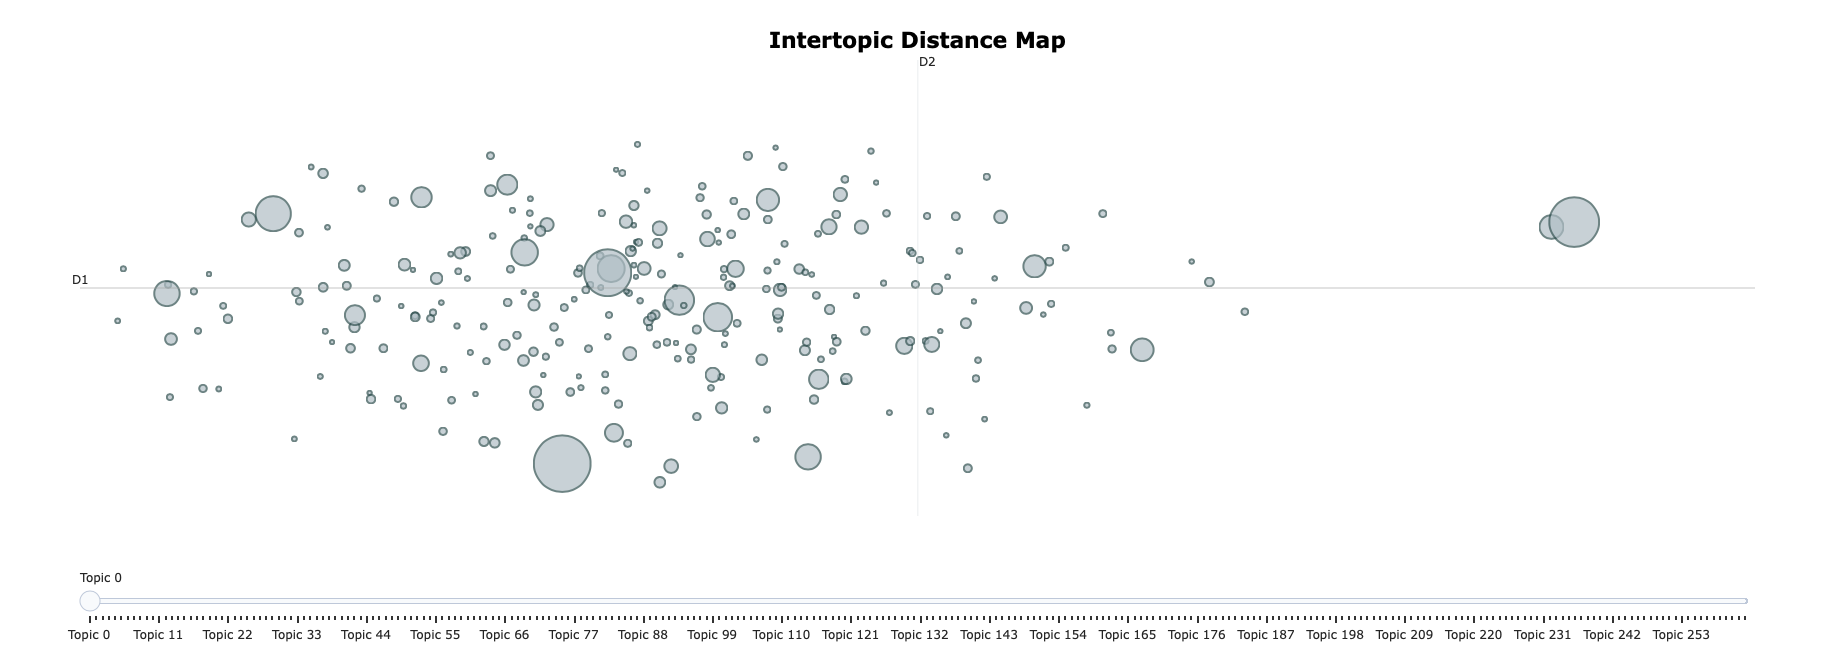

In [25]:
topic_model.visualize_topics()

In [26]:
hate_df['topic'] = pd.Series(topics)

In [27]:
def list_to_str(ls):
    string = ' '.join(str(item) for item in ls)
    return string

In [28]:
hate_df['prompt_raw'] = hate_df['topic'].apply(lambda x: list(dict(topic_model.get_topic(x)[:13]).keys()))
hate_df['prompt'] = hate_df['prompt_raw'].parallel_apply(list_to_str)

In [29]:
hate_df.head()

index                                id  is_hater  \
0      0  1a698d93874644625d83a76b206c7aa3         0   
1      1  1a698d93874644625d83a76b206c7aa3         0   
2      2  1a698d93874644625d83a76b206c7aa3         0   
3      3  1a698d93874644625d83a76b206c7aa3         0   
4      4  1a698d93874644625d83a76b206c7aa3         0   

                                              tweets  \
0  RT #USER#: Esperando para ver la captura de Ja...   
1  #USER# #USER# Que bueno Romeo con la ayuda De ...   
2  RT #USER#: Nuestras cuadrillas están restauran...   
3  RT #USER#: Esta es la portada de #HASHTAG# de ...   
4  RT #USER#: Lo más matado de la risa que vas a ...   

                                    processed_tweets  len_initial  \
0  rt user esperando para ver la captura de jaime...           56   
1  user user que bueno romeo con la ayuda de dios...           73   
2  rt user nuestras cuadrillas están restaurando ...          102   
3  rt user esta es la portada de hashtag de este ...          105   
4  rt user lo más matado de la risa que vas a ver...           60   

   len_processed  topic                                         prompt_raw  \
0             52     -1  [ver, gente, vida, gracias, hoy, ni, voy, eres...   
1             69     -1  [ver, gente, vida, gracias, hoy, ni, voy, eres...   
2             96     -1  [ver, gente, vida, gracias, hoy, ni, voy, eres...   
3             93    178  [marzo, febrero, enero, octubre, portada, dici...   
4             54     -1  [ver, gente, vida, gracias, hoy, ni, voy, eres...   

                                              prompt  
0  ver gente vida gracias hoy ni voy eres solo hacer  
1  ver gente vida gracias hoy ni voy eres solo hacer  
2  ver gente vida gracias hoy ni voy eres solo hacer  
3  marzo febrero enero octubre portada diciembre ...  
4  ver gente vida gracias hoy ni voy eres solo hacer

In [30]:
hate_df['topic'].value_counts().head(30)

-1      32025
 199     2742
 215     2110
 237     1884
 263     1053
 118      738
 51       693
 209      623
 167      596
 65       550
 260      549
 208      487
 34       444
 7        425
 93       425
 185      355
 222      345
 205      342
 191      322
 72       274
 233      231
 19       225
 119      209
 76       197
 231      193
 48       182
 120      175
 189      172
 81       168
 197      159
Name: topic, dtype: int64

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [32]:
pd.crosstab(hate_df['topic'],hate_df['is_hater']).describe(percentiles=[.25, .5, .75, .8, .85, .9, .95])

is_hater             0             1             2
count       265.000000    265.000000    265.000000
mean         75.471698     75.471698     75.471698
std         660.453856    665.649358    652.980979
min           0.000000      0.000000      1.000000
25%           8.000000      8.000000      9.000000
50%          13.000000     15.000000     14.000000
75%          25.000000     28.000000     26.000000
80%          33.000000     34.000000     31.000000
85%          41.000000     41.000000     41.000000
90%          60.200000     57.800000     58.600000
95%         154.600000    126.600000    143.600000
max       10689.000000  10773.000000  10563.000000

In [33]:
pd.crosstab(hate_df['topic'],hate_df['id']).T.describe(percentiles=[.25, .5, .75, .8, .85, .9, .95])

topic        -1           0           1           2           3           4    \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean   106.750000    0.116667    0.063333    0.163333    0.166667    0.206667   
std     10.482068    0.811532    0.653769    0.473359    0.503056    0.527462   
min     80.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    100.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%    108.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%    114.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
80%    116.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
85%    117.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
90%    119.100000    0.000000    0.000000    1.000000    1.000000    1.000000   
95%    123.000000    1.000000    0.000000    1.000000    1.000000    1.000000   
max    135.000000   13.000000   11.000000    3.000000    5.000000    4.000000   

topic         5           6           7           8           9           10   \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.106667    0.310000    1.416667    0.153333    0.060000    0.113333   
std      0.340109    0.664861    1.450310    0.480199    0.288694    0.392857   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    2.000000    0.000000    0.000000    0.000000   
80%      0.000000    1.000000    3.000000    0.000000    0.000000    0.000000   
85%      0.000000    1.000000    3.000000    0.000000    0.000000    0.000000   
90%      0.100000    1.000000    3.000000    1.000000    0.000000    0.000000   
95%      1.000000    1.000000    4.000000    1.000000    0.000000    1.000000   
max      3.000000    5.000000    7.000000    4.000000    2.000000    3.000000   

topic         11          12          13          14          15          16   \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.210000    0.120000    0.286667    0.173333    0.230000    0.073333   
std      0.522951    0.399331    0.716146    2.150668    0.710951    0.418576   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
80%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
85%      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
90%      1.000000    0.000000    1.000000    0.000000    1.000000    0.000000   
95%      1.000000    1.000000    2.000000    0.000000    1.000000    1.000000   
max      3.000000    3.000000    5.000000   37.000000    6.000000    6.000000   

topic         17          18          19          20          21          22   \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.106667    0.280000    0.750000    0.056667    0.136667    0.310000   
std      0.359239    0.802338    1.106759    0.271480    0.414602    0.617932   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
80%      0.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
85%      0.000000    1.000000    2.000000    0.000000    0.000000    1.000000   
90%      0.000000    1.00000

#not treally that much unique author-related topics for the chosen set of berttopic parameters

In [34]:
hate_df.head()

index                                id  is_hater  \
0      0  1a698d93874644625d83a76b206c7aa3         0   
1      1  1a698d93874644625d83a76b206c7aa3         0   
2      2  1a698d93874644625d83a76b206c7aa3         0   
3      3  1a698d93874644625d83a76b206c7aa3         0   
4      4  1a698d93874644625d83a76b206c7aa3         0   

                                                                                                      tweets  \
0                                                   RT #USER#: Esperando para ver la captura de Jaime Perla.   
1                                  #USER# #USER# Que bueno Romeo con la ayuda De Dios serás un buen diputado   
2     RT #USER#: Nuestras cuadrillas están restaurando paredes en el Centro Histórico de San Salvador. #URL#   
3  RT #USER#: Esta es la portada de #HASHTAG# de este jueves 04 de marzo del 2021. #HASHTAG# #HASHTAG# #URL#   
4                                               RT #USER#: Lo más matado de la risa que vas a ver hoy: #URL#   

                                                                                   processed_tweets  \
0                                              rt user esperando para ver la captura de jaime perla   
1                             user user que bueno romeo con la ayuda de dios serás un buen diputado   
2  rt user nuestras cuadrillas están restaurando paredes en el centro histórico de san salvador url   
3     rt user esta es la portada de hashtag de este jueves 04 de marzo del 2021 hashtag hashtag url   
4                                            rt user lo más matado de la risa que vas a ver hoy url   

   len_initial  len_processed  topic  \
0           56             52     -1   
1           73             69     -1   
2          102             96     -1   
3          105             93    178   
4           60             54     -1   

                                                                              prompt_raw  \
0                           [ver, gente, vida, gracias, hoy, ni, voy, eres, solo, hacer]   
1                           [ver, gente, vida, gracias, hoy, ni, voy, eres, solo, hacer]   
2                           [ver, gente, vida, gracias, hoy, ni, voy, eres, solo, hacer]   
3  [marzo, febrero, enero, octubre, portada, diciembre, abril, mayo, noviembre, shakira]   
4                           [ver, gente, vida, gracias, hoy, ni, voy, eres, solo, hacer]   

                                                                       prompt  
0                           ver gente vida gracias hoy ni voy eres solo hacer  
1                           ver gente vida gracias hoy ni voy eres solo hacer  
2                           ver gente vida gracias hoy ni voy eres solo hacer  
3  marzo febrero enero octubre portada diciembre abril mayo noviembre shakira  
4                           ver gente vida gracias hoy ni voy eres solo hacer

In [35]:
hate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             60000 non-null  int64 
 1   id                60000 non-null  object
 2   is_hater          60000 non-null  int64 
 3   tweets            60000 non-null  object
 4   processed_tweets  60000 non-null  object
 5   len_initial       60000 non-null  int64 
 6   len_processed     60000 non-null  int64 
 7   topic             60000 non-null  int64 
 8   prompt_raw        60000 non-null  object
 9   prompt            60000 non-null  object
dtypes: int64(5), object(5)
memory usage: 4.6+ MB


In [36]:
hate_df.to_csv("train_test_es.csv")

In [37]:
hate_df['hater_prefix'] = 'hater classification' 
hate_df['topic_prefix'] = 'topic classification'
hate_df['author_prefix'] = 'authorship identification'
#hate_df['bert_adversarial_prefix'] = 'bertattack identification'
#hate_df['ga_adversarial_prefix'] = 'ga attack identification'
hate_df['len_diff'] = hate_df['len_initial'] - hate_df['len_processed']

#adding prefixes 4 t5

In [38]:
hate_df['len_diff'].describe()

count    60000.000000
mean         5.198317
std          3.483919
min         -3.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         72.000000
Name: len_diff, dtype: float64

In [39]:
hate_df[hate_df['topic']==-1]['len_diff'].describe()

count    32025.000000
mean         5.281998
std          3.505217
min         -3.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         72.000000
Name: len_diff, dtype: float64

#looks like there is no real impact of preprocessing on topic identificaiton

In [40]:
def rename(x):
    if x==1:
        x="hatespeach"
    elif x==0:
        x="neutral"
    else:
        x="unknown"
    return x

In [41]:
hater_train_df = hate_df.drop(columns = list(set(hate_df.columns)-set(['hater_prefix','processed_tweets','is_hater'])))
hater_train_df['hate_speach'] = hate_df['is_hater'].parallel_apply(rename)
hater_train_df = hater_train_df.drop(columns=['is_hater'])
hater_train_df = hater_train_df[hater_train_df.hate_speach != "unknown"]
hater_train_df=hater_train_df.rename(columns={"hater_prefix":"prefix","processed_tweets":"input_text","hate_speach":"target"})
hater_train_cut_df, hater_eval_df = train_test_split(hater_train_df, test_size=0.15)

In [42]:
hater_train_df.head()

input_text  \
0                                              rt user esperando para ver la captura de jaime perla   
1                             user user que bueno romeo con la ayuda de dios serás un buen diputado   
2  rt user nuestras cuadrillas están restaurando paredes en el centro histórico de san salvador url   
3     rt user esta es la portada de hashtag de este jueves 04 de marzo del 2021 hashtag hashtag url   
4                                            rt user lo más matado de la risa que vas a ver hoy url   

                 prefix   target  
0  hater classification  neutral  
1  hater classification  neutral  
2  hater classification  neutral  
3  hater classification  neutral  
4  hater classification  neutral

In [43]:
def rename1(x):
    return "class: "+str(x)

In [44]:
topic_train_df = hate_df.drop(columns = list(set(hate_df.columns)-set(['topic_prefix','processed_tweets','topic'])))
topic_train_df['topic_class'] = hate_df['topic'].parallel_apply(rename1)
topic_train_df = topic_train_df.drop(columns=['topic'])
topic_train_df = topic_train_df.rename(columns={"processed_tweets":"input_text","topic_prefix":"prefix","topic_class":"target"})
topic_train_cut_df, topic_eval_df = train_test_split(topic_train_df, test_size=0.15)

In [45]:
topic_train_df.head()

input_text  \
0                                              rt user esperando para ver la captura de jaime perla   
1                             user user que bueno romeo con la ayuda de dios serás un buen diputado   
2  rt user nuestras cuadrillas están restaurando paredes en el centro histórico de san salvador url   
3     rt user esta es la portada de hashtag de este jueves 04 de marzo del 2021 hashtag hashtag url   
4                                            rt user lo más matado de la risa que vas a ver hoy url   

                 prefix      target  
0  topic classification   class: -1  
1  topic classification   class: -1  
2  topic classification   class: -1  
3  topic classification  class: 178  
4  topic classification   class: -1

In [46]:
author_train_df = hate_df.drop(columns = list(set(hate_df.columns)-set(['author_prefix','processed_tweets','id'])))
author_train_df = author_train_df.rename(columns={"processed_tweets":"input_text","author_prefix":"prefix","id":"target"})
author_train_cut_df, author_eval_df = train_test_split(author_train_df, test_size=0.2)

In [47]:
author_train_df.head()

target  \
0  1a698d93874644625d83a76b206c7aa3   
1  1a698d93874644625d83a76b206c7aa3   
2  1a698d93874644625d83a76b206c7aa3   
3  1a698d93874644625d83a76b206c7aa3   
4  1a698d93874644625d83a76b206c7aa3   

                                                                                         input_text  \
0                                              rt user esperando para ver la captura de jaime perla   
1                             user user que bueno romeo con la ayuda de dios serás un buen diputado   
2  rt user nuestras cuadrillas están restaurando paredes en el centro histórico de san salvador url   
3     rt user esta es la portada de hashtag de este jueves 04 de marzo del 2021 hashtag hashtag url   
4                                            rt user lo más matado de la risa que vas a ver hoy url   

                      prefix  
0  authorship identification  
1  authorship identification  
2  authorship identification  
3  authorship identification  
4  authorship identification

In [48]:
train_df = pd.concat([hater_train_df, topic_train_df, author_train_df]).astype(str)
#eval_df = pd.concat([hater_eval_df, topic_eval_df, author_eval_df]).astype(str)

In [49]:
train_df.reset_index(inplace = True)

In [54]:
train_df.to_csv("train_es_df.csv")

In [51]:
conditional_train_df = hate_df.drop(columns = list(set(hate_df.columns)-set(['prompt','processed_tweets','is_hater'])))
conditional_train_df['hate_speach'] = hate_df['is_hater'].parallel_apply(rename)
conditionalr_train_df = conditional_train_df.drop(columns=['is_hater'])
conditional_train_df = conditional_train_df[conditional_train_df.hate_speach != "unknown"]
conditional_train_df=conditional_train_df.rename(columns={"prompt":"prefix","processed_tweets":"input_text","hate_speach":"target"}).astype('str')
conditional_train_cut_df, conditional_eval_df = train_test_split(conditionalr_train_df, test_size=0.2)

In [52]:
conditional_eval_df.to_csv("conditional_eval_df.csv")
conditional_train_df.to_csv("conditional_train_df.csv")

In [53]:
conditional_train_df.head()

is_hater  \
0        0   
1        0   
2        0   
3        0   
4        0   

                                                                                         input_text  \
0                                              rt user esperando para ver la captura de jaime perla   
1                             user user que bueno romeo con la ayuda de dios serás un buen diputado   
2  rt user nuestras cuadrillas están restaurando paredes en el centro histórico de san salvador url   
3     rt user esta es la portada de hashtag de este jueves 04 de marzo del 2021 hashtag hashtag url   
4                                            rt user lo más matado de la risa que vas a ver hoy url   

                                                                       prefix  \
0                           ver gente vida gracias hoy ni voy eres solo hacer   
1                           ver gente vida gracias hoy ni voy eres solo hacer   
2                           ver gente vida gracias hoy ni voy eres solo hacer   
3  marzo febrero enero octubre portada diciembre abril mayo noviembre shakira   
4                           ver gente vida gracias hoy ni voy eres solo hacer   

    target  
0  neutral  
1  neutral  
2  neutral  
3  neutral  
4  neutral